# Filter-and-Fire Neuron Model

## Background

In this notebook, we aim to use a different biological neuron model than the LIF neuron used in the SNN trained for the sound localisation task. 

[Beniaguev et al. (2022, preprint)](https://www.biorxiv.org/content/10.1101/2022.01.28.478132v2.abstract) recently proposed the filter-and-fire neuron, which takes inspiration from the neurobiological finding that presynaptic neurons make more than one synaptic contact on the dendrites of their "target" postsynaptic neuron. These synaptic contacts can be made at various locations on the dendritic tree of the postsynaptic neuron, i.e., at various distances from the neuron's soma (see Figure 1 in the paper).

Below, we highlight the sequential steps in which we aim to introduce/adapt this neuron model in this project. You can have a look at these couple of slides for some high-level overview: [Google Slides](https://docs.google.com/presentation/d/1XMqWLDBRnLCNdStXknKGdnDYZfWRdgFE2QmzbV0vbgk/edit?usp=sharing).

In brief, we think the presence of multiple synaptic connections at different distances on the dendritic tree of the postsynaptic neuron can be useful for the project's training. 
- With multiple synaptic connections made by the same presynaptic neuron's axon, we get individual PSPs (i.e., for each contact that axon makes on the postsynaptic dendrites) with *different temporal profiles*.
    - the further from the postsynaptic neuron's soma a synaptic connection is, the "broader" the temporal profile of the resulting individual PSP from that connection is. 
    - these PSPs with different temporal profiles from one presynaptic axon are summed to make up the postsynaptic neuron's somatic response for inputs coming from that axon. 
- We can tune the weights at the synaptic contacts made by each presynaptic neuron's axon to adjust the magnitude and timing of the peak of the summed postsynaptic somatic response for each presynaptic axon. 
- We hypothesise that this will increase performance by allowing the network to tune the delays associated with different inputs (compared to, e.g., training the delays).

### Ideas to adapt filter-and-fire neuron model in the sound localisation SNN (step-by-step)

Note: 
- `presynaptic_input_spikes_tensor`: the original spike train inputs
- tau: synaptic time constant
- M: number of connections per presynaptic axon. This is > 1 in Exp 3 only.

Main idea: Apply smoothing to the `presynaptic_input_spikes_tensor` to get PSP-like inputs, by convolving the original input spike trains with a normalised filter.

- Exp 1. convolve input_spikes with one single filter, with fixed tau hyperparameters (use Beniaguev code to create filter shape, turn this into tensor)
- Exp 2. convolve input_spikes with different, random filters (try with, and without delay ranges = a random fixed delay value or just 0); here, we don't use fixed tau hyperparameters and instead randomly sample them from predefined ranges.
- Exp 3. use filter-and-fire neurons (e.g. M = 3 connections per axon)

## TO-DOs
(As of end of Dec 2022)
- Section on Exp 3.
    - action: I have an implementation of this (trained it too) but need to check it before adding it to the end of this notebook. 
    - action: once an implementation has been confirmed to work appropriately, I will train and test this for more epochs using UCL's compute.
- Exp 2. 
    - is relatively poor performance of random taus because, on average, the PSP widths are wider than in the single, fixed tau case in Exp 1 (i.e. too much smoothing with the random filters)?
        - action: train for more epochs (will do with UCL's compute in January)
- Training duration
    - action: in general, I need to train for more than 100 epochs (will do with UCL's compute in January)
- Hyperparameter tuning
    - action: can do a search to optimise the hyperparameters (esp. the tau hyperparameters, to find the optimal synaptic time constants) for example
    - action: can test out [Weights and Biases](https://wandb.ai/site)
- Other extension ideas
    - examples: to improve the performance; to gain more insight into the network...

## Imports

In [1]:
!pip install tqdm

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn as nn

from tqdm.auto import tqdm as pbar

dtype = torch.float

# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")     
else:
    device = torch.device("cpu")
    
my_computer_is_slow = True # set this to True if using Colab

## Hyperparameters

In [2]:
# Constants
SECOND = 1
MS = 1e-3
HZ = 1
PI = np.pi
DT = 1*MS # large time step to make simulations run faster

ANF_PER_EAR = 100    # repeats of each ear with independent noise (was 1000 in my other notebooks)
ENVELOPE_POWER = 2   # higher values make sharper envelopes, easier
RATE_MAX = 600*HZ   # maximum Poisson firing rate
F = 20*HZ           # stimulus frequency
DURATION = .1*SECOND # stimulus duration
DURATION_STEPS = int(np.round(DURATION/DT)) # 100
T = np.arange(DURATION_STEPS)*DT # array of times

# Network
INPUT_SIZE = 2*ANF_PER_EAR # 200 input neurons
NUM_HIDDEN = 30
NUM_CLASSES = 180//15 # classes at 15 degree increments
print('Number of classes = {}'.format(NUM_CLASSES))
TAU = 5*MS # this used to be 20 in the SNN Starting Notebook, is now 5 in Quick Start Notebook

# Training
MY_COMPUTER_IS_SLOW = True
if MY_COMPUTER_IS_SLOW:
    BATCH_SIZE = 64
    N_TRAINING_BATCHES = 64
else:
    BATCH_SIZE = 128
    N_TRAINING_BATCHES = 128
N_TESTING_BATCHES = 32
NUM_SAMPLES = BATCH_SIZE*N_TRAINING_BATCHES
BETA = 5 # for Surrogate Gradient Descent
NUM_EPOCHS = 100 # (takes ~6min/epoch with INPUT_SIZE=200)
LR = 0.0001

# Filter-and-Fire Neuron Model (Beniaguev et al., 2022)
NUM_AXONS = 100
CONNECTIONS_PER_AXON = 2
NUM_SYNAPSES = CONNECTIONS_PER_AXON * NUM_AXONS
 



Number of classes = 12


## Functions

### Stimulus

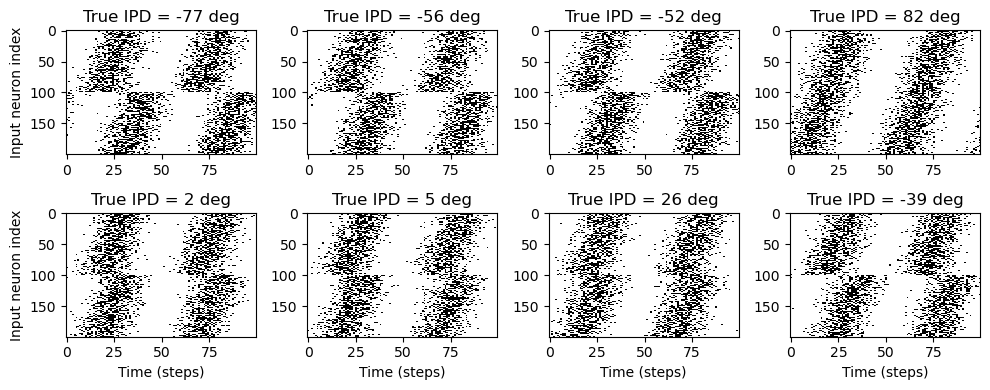

In [3]:
def input_signal(ipd, usual_phase_delays=True):
    """
    Generate an input signal (spike array) from array of true IPDs
  
    Parameters:
    ipd (array): true IPDs
  
    Returns:
    spikes (array): input signal from true IPDs (spike trains)
  
    """
    
    num_samples = len(ipd) # i.e., NUM_SAMPLES
    phi = 2*PI*(F*T+np.random.rand()) # array of phases corresponding to those times with random offset
 
    # each point in the array will have a different phase based on which ear it is
    # and its delay
    theta = np.zeros((num_samples, DURATION_STEPS, 2*ANF_PER_EAR))
    
    # for each ear, we have anf_per_ear different phase delays from to pi/2 so
    # that the differences between the two ears can cover the full range from -pi/2 to pi/2
    if usual_phase_delays: # Exp 1., Exp 2.a
        phase_delays = np.linspace(0, PI/2, ANF_PER_EAR)
    else: # Exp 2.b, Exp 3.
        phase_delays = np.linspace(0, 0, ANF_PER_EAR)

    # now we set up these theta to implement that. Some numpy vectorisation logic here which looks a little weird,
    # but implements the idea in the text above.
    theta[:, :, :ANF_PER_EAR] = phi[np.newaxis, :, np.newaxis]+phase_delays[np.newaxis, np.newaxis, :]
    theta[:, :, ANF_PER_EAR:] = phi[np.newaxis, :, np.newaxis]+phase_delays[np.newaxis, np.newaxis, :]+ipd[:, np.newaxis, np.newaxis]

    # now generate Poisson spikes at the given firing rate as in the previous notebook
    spikes = np.random.rand(num_samples, DURATION_STEPS, 2*ANF_PER_EAR)<RATE_MAX*DT*(0.5*(1+np.sin(theta)))**ENVELOPE_POWER

    return spikes

# Generate some true IPDs from U(-pi/2, pi/2) and corresponding spike arrays
def random_ipd_input_signal(num_samples, usual_phase_delays=True, tensor=True):
    """
    Generate the training data: true IPDs are in U(-pi/2, pi/2) 
  
    Parameters:
    num_samples (int)
    usual_phase_delays (boolean): flag on the use of usual or null phase delays
    tensor (boolean): flag on the use of tensor or numpy objects for the objects returned
  
    Returns:
    ipd (array): true IPDs from U(-pi/2, pi/2)
    spikes (array): input signal corresponding to the true IPDs in the training data
  
    """

    ipd = np.random.rand(num_samples)*PI-PI/2 # uniformly random in (-pi/2, pi/2)
    #print(ipd)# okay
    spikes = input_signal(ipd, usual_phase_delays)
    #print(spikes) # empty
    
    if tensor:
        ipd = torch.tensor(ipd, device=device, dtype=dtype)        
        spikes = torch.tensor(spikes, device=device, dtype=dtype)
        
    return ipd, spikes


def discretise(ipds):
    """
    Discretise the ipds in the training data 
  
    Parameters:
    ipds (tensor)
  
    Returns:
    tensor
  
    """
    return ((ipds+PI/2)*NUM_CLASSES/PI).long() # assumes input is tensor

def continuise(ipd_indices): # convert indices back to IPD midpoints
    """
    Undo the discretisation of ipds
  
    Parameters:
    ipd_indices (array)
  
    Returns:
    array
  
    """
    return (ipd_indices+0.5)/NUM_CLASSES*PI-PI/2


# Generator function iterates over the data in batches
# We randomly permute the order of the data to improve learning
def data_generator(ipds, spikes):
    """
    Generate the whole training data by iterating over the data in the batches.
    Order of the data is randomly permuted to improve learning.
  
    Parameters:
    ipds (tensor)
    spikes (tensor): flag on the use of usual or null phase delays
  
    Yields:
    x_local (tensor): relates to the spikes
    y_local (tensor): relates to the ipds
  
    """
    
    perm = torch.randperm(spikes.shape[0])
    spikes = spikes[perm, :, :]
    ipds = ipds[perm]
    n, _, _ = spikes.shape
    n_batch = n//BATCH_SIZE
    
    for i in range(n_batch):
        x_local = spikes[i*BATCH_SIZE:(i+1)*BATCH_SIZE, :, :]
        y_local = ipds[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        
        yield x_local, y_local

# Plot a few just to show how it looks
def plot_some_input_examples(num_examples=8):
    """
    Plots some example inputs.
  
    Parameters:
    num_examples (int): default = 8
  
    """
    
    ipd, spikes = random_ipd_input_signal(num_examples)
    spikes = spikes.cpu()
    plt.figure(figsize=(10, 4), dpi=100)
    for i in range(num_examples):
        plt.subplot(2, 4, i+1)
        plt.imshow(spikes[i, :, :].T, aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)
        plt.title(f'True IPD = {int(ipd[i]*180/PI)} deg')
        if i>=4:
            plt.xlabel('Time (steps)')
        if i%4==0:
            plt.ylabel('Input neuron index')
        plt.tight_layout()
    
    
plot_some_input_examples()

### SNN

In [4]:
class SurrGradSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        # Original SPyTorch/SuperSpike gradient
        # This seems to be a typo or error? But it works well
        #grad = grad_output/(100*torch.abs(input)+1.0)**2
        # Sigmoid
        grad = grad_output*BETA*torch.sigmoid(BETA*input)*(1-torch.sigmoid(BETA*input))
        return grad

spike_fn  = SurrGradSpike.apply

# Run the simulation
def snn(presynaptic_input_spikes_tensor, W1, W1_bis, W2, 
        multiple_connections_per_axon,
        random_tau_constants, 
        minimal_smoothing):
    
    """
    Runs the SNN simulation.
  
    Parameters:
    presynaptic_input_spikes_tensor (tensor): corresponds to x_local in the training
    W1 (tensor): initialised trainable weight parameter for the first layer
    W1_bis (tensor): fixed non-trainable weight parameter for the first layer when there are multiple connections per axon
    W2 (tensor): initialised trainable weight parameter for the second layer
    multiple_connections_per_axon (boolean): flag on the use of multiple connections per axon
    random_tau_constants (boolean): flag on the use of randomly sampled tau hyperparameters (rise and decay)
    minimal_smoothing: flag on the use of fast tau hyperparameters for minimal input spike smoothing
  
    Returns:
    v_rec (tensor): recorded membrane potential of output
    input_smoothed (tensor): smoothed inputs
  
    """
    
    # First layer: input to hidden
    v = torch.zeros((BATCH_SIZE, NUM_HIDDEN), device=device, dtype=dtype)
    s = torch.zeros((BATCH_SIZE, NUM_HIDDEN), device=device, dtype=dtype)
    s_rec = [s]

    # Get smoothed inputs (binary spike train -> PSP shapes)
    input_smoothed = getDoubleExpFilteredSpikes_allBatchExamples(presynaptic_input_spikes_tensor, 
                                                                 random_tau_constants,
                                                                 minimal_smoothing)
    
    if multiple_connections_per_axon: # for Exp 3.
        pre_h = torch.einsum("abc,cd->abd", (input_smoothed, W1))
        h = torch.einsum("abc,cd->abd", (pre_h, W1_bis)) # (BATCH_SIZE, DURATION_STEPS, NUM_HIDDEN)
    else:
        h = torch.einsum("abc,cd->abd", (input_smoothed, W1))
    
    alpha = np.exp(-DT/TAU)
    for t in range(DURATION_STEPS - 1):  
        new_v = (alpha*v + h[:, t, :])*(1-s) # multiply by 0 after a spike (similar to soma_current) 
        s = spike_fn(v-1) # threshold of 1
        v = new_v
        s_rec.append(s)
    s_rec = torch.stack(s_rec, dim=1)
    
    # Second layer: hidden to output
    v = torch.zeros((BATCH_SIZE, NUM_CLASSES), device=device, dtype=dtype)
    s = torch.zeros((BATCH_SIZE, NUM_CLASSES), device=device, dtype=dtype)
    v_rec = [v]
    h = torch.einsum("abc,cd->abd", (s_rec, W2))
    alpha = np.exp(-DT/TAU)
    for t in range(DURATION_STEPS - 1):  
        v = alpha*v + h[:, t, :]
        v_rec.append(v)
    v_rec = torch.stack(v_rec, dim=1)
    
    # Return recorded membrane potential of output and smoothed input (for visualisation)
    return v_rec, input_smoothed

### Training

In [10]:
# Weights and uniform weight initialisation
def init_weight_matrix():
    """
    Initialises the weight matrix used in the fanin-fanout calculations for the initialisation of W1 and W2.
  
    Parameters:
    None
    
    Returns:
    W (tensor): weight tensor used in fanin-fanout calculations
  
    """

    W = nn.Parameter(torch.empty((INPUT_SIZE, NUM_CLASSES), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(W, -bound, bound)
    
    return W

def init_weight_matrices(W, multiple_connections_per_axon=False):
    """
    Initialises the weight matrices in the SNN: W1, W1_bis and W2.
  
    Parameters:
    W (tensor): weight tensor used in fanin-fanout calculations for W1 and W2
    multiple_connections_per_axon (boolean): flag on the use of multiple connections per axon
  
    Returns:
    W1 (tensor): initialised trainable weight parameter for the first layer
    W1_bis (tensor): fixed non-trainable weight parameter for the first layer when there are multiple connections per axon
    W2 (tensor): initialised trainable weight parameter for the second layer
  
    """
    
    if multiple_connections_per_axon: # Exp. 3
        # Input to hidden layer
        W1 = nn.Parameter(torch.empty((INPUT_SIZE, NUM_HIDDEN*CONNECTIONS_PER_AXON), device=device, dtype=dtype, requires_grad=True))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W)
        bound = 1 / np.sqrt(fan_in)
        nn.init.uniform_(W1, -bound, bound)
    
        # don't make W1_bis trainable
        W1_bis = torch.zeros(NUM_HIDDEN*CONNECTIONS_PER_AXON, NUM_HIDDEN)
        for i in range(W1_bis.shape[0]):
            if i == 0:
                W1_bis[i,i] = 1
            elif i % 2 == 1:
                W1_bis[i,i//2] = 1
            elif i % 2 == 0:  # excluding 0
                W1_bis[i,int(i/2)] = 1 
    
        # Hidden layer to output
        W2 = nn.Parameter(torch.empty((NUM_HIDDEN, NUM_CLASSES), device=device, dtype=dtype, requires_grad=True))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W)
        bound = 1 / np.sqrt(fan_in)
        nn.init.uniform_(W2, -bound, bound)
        
    else:
        # Input to hidden layer
        W1 = nn.Parameter(torch.empty((INPUT_SIZE, NUM_HIDDEN), device=device, dtype=dtype, requires_grad=True))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W)
        bound = 1 / np.sqrt(fan_in)
        nn.init.uniform_(W1, -bound, bound)
        
        # placeholder for W1_bis (not used)
        W1_bis = torch.zeros(NUM_HIDDEN*CONNECTIONS_PER_AXON, NUM_HIDDEN)
    
        # Hidden layer to output
        W2 = nn.Parameter(torch.empty((NUM_HIDDEN, NUM_CLASSES), device=device, dtype=dtype, requires_grad=True))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W)
        bound = 1 / np.sqrt(fan_in)
        nn.init.uniform_(W2, -bound, bound)
        
    return W1, W1_bis, W2
    
    
def train(ipds, spikes, usual_phase_delays=True, multiple_connections_per_axon=False, random_tau_constants=False, minimal_smoothing=False):
    """
    Runs the training of the SNN simulation.
  
    Parameters:
    usual_phase_delays (boolean): flag on the use of usual or null phase delays
    multiple_connections_per_axon (boolean): flag on the use of multiple connections per axon
    random_tau_constants (boolean): flag on the use of randomly sampled tau hyperparameters (rise and decay)
    minimal_smoothing (boolean): flag on the use of fast tau hyperparameters for minimal input spike smoothing
  
    Returns:
    ipds (tensor): training data (y)
    spikes (tensor): training data (X)
    W1 (tensor): trained W1
    W2 (tensor): trained W2
    snn_training_snapshot (list): snapshots of the training at each epoch
  
    """
    
    # Generate the training data
    #ipds, spikes = random_ipd_input_signal(NUM_SAMPLES, usual_phase_delays)
    
    # Initialise weight matrices
    W = init_weight_matrix() # for fan_in/out calculations
    W1, W1_bis, W2 = init_weight_matrices(W, multiple_connections_per_axon)

    # Optimiser and loss function
    optimizer = torch.optim.Adam([W1, W2], lr=LR)
    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()

    loss_hist = []
    snn_training_snapshot = []
    
    for e in pbar(range(NUM_EPOCHS)):
        
        local_loss = []
        batch_number = 0
        
        print('--------------------------------------------------------')
        print("EPOCH {}".format(e+1))
        
        for x_local, y_local in data_generator(discretise(ipds), spikes):
            
            batch_number += 1
            
            # Run network
            output, input_smoothed = snn(x_local, W1, W1_bis, W2, multiple_connections_per_axon, random_tau_constants, minimal_smoothing)
            
            # Compute cross entropy loss
            #m = torch.sum(output, 1)*0.01  # Sum time dimension
            # Compute cross entropy loss
            m = torch.mean(output, 1)  # Mean across time dimension

            reg = 0 # to add regularisation later if wanted
            loss = loss_fn(log_softmax_fn(m), y_local) + reg
            local_loss.append(loss.item())

            # Update gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Record and print the loss of the current epoch
        loss_hist.append(np.mean(local_loss))
        print("---EPOCH %i: LOSS=%.5f"%(e+1, np.mean(local_loss)))

        # Plot raster plot: 
        # e.g. input_smoothed for the 1st example of the last batch of the current epoch
        #print("---Raster Plots at Epoch {} - Example #1/64 of the Last Batch Group".format(e+1))
        #plt.figure(1)
        #plt.title("input_smoothed example vs corresponding initial spike train")
        #plt.subplot(211)
        #plt.imshow(input_smoothed[0, :, :].detach().numpy().T, aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)
        #plt.xlabel('Time (steps)')
        #plt.ylabel('Input neuron index')
        #plt.subplot(212)
        #plt.imshow(x_local[0, :, :].detach().numpy().T, aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)
        #plt.xlabel('Time (steps)')
        #plt.ylabel('Input neuron index')
    
        #plt.show()
        
        # Take a snapshot of the model at the end of the current epoch. 
        ## Use cases:
        ### if we want to resume training from this current epoch,
        ### or if the training is halted before the last epoch
        snn_training_snapshot.append({'W1':W1, 'W2':W2, 
                                      'multiple_connections_per_axon':multiple_connections_per_axon, 
                                      'random_tau_constants':random_tau_constants, 
                                      'minimal_smoothing':minimal_smoothing}) 
        
    # Plot the loss function over time
    plt.plot(loss_hist)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.tight_layout()

    # return the train dataset (ipds, spikes) and trained weights for analysis
    # also return the list of model snapshots for each epoch (in case we want to resume training)
    return W1, W1_bis, W2, snn_training_snapshot


### Train and Test Performance of the Trained Model 

In [6]:
def get_accuracy(ipds, spikes, run):
    """
    Gets the accuracy on data (train or test)
  
    Parameters:
    ipds (tensor)
    spikes (tensor)
    run (lambda function)
  
    Returns:
    ipd_true (list)
    ipd_est (list)
    confusion (numpy array)
    accs (list)
  
    """
    
    accs = []
    ipd_true = []
    ipd_est = []
    confusion = np.zeros((NUM_CLASSES, NUM_CLASSES))
    
    #print(ipds.shape)
    #print(spikes.shape)
    
    for x_local, y_local in data_generator(ipds, spikes):
        y_local_orig = y_local
        y_local = discretise(y_local)
        output, _ = run(x_local)
        #m = torch.sum(output, 1)  # Sum time dimension
        m = torch.mean(output, 1)
        _, am = torch.max(m, 1)  # argmax over output units
        tmp = np.mean((y_local == am).detach().cpu().numpy())  # compare to labels
        
        for i, j in zip(y_local.detach().cpu().numpy(), am.detach().cpu().numpy()):
            confusion[j, i] += 1
            
        ipd_true.append(y_local_orig.cpu().data.numpy())
        ipd_est.append(continuise(am.detach().cpu().numpy()))
        accs.append(tmp)

    ipd_true = np.hstack(ipd_true)
    ipd_est = np.hstack(ipd_est)

    return ipd_true, ipd_est, confusion, accs

def report_accuracy(ipd_true, ipd_est, confusion, accs, label):
    """
    Plots the accuracy on data (train or test).
  
    Parameters:
    ipd_true (list)
    ipd_est (list)
    confusion (numpy array)
    accs (list)
    label (string): "Test" or "Train"
  
    Returns:
    None
  
    """

    abs_errors_deg = abs(ipd_true-ipd_est)*180/PI

    print()
    print(f"{label} classifier accuracy: {100*np.mean(accs):.1f}%")
    print(f"{label} absolute error: {np.mean(abs_errors_deg):.1f} deg")

    plt.figure(figsize=(10, 4), dpi=100)
    plt.subplot(121)
    plt.hist(ipd_true * 180 / PI, bins=NUM_CLASSES, label='True')
    plt.hist(ipd_est * 180 / PI, bins=NUM_CLASSES, label='Estimated')
    plt.xlabel("IPD")
    plt.yticks([])
    plt.legend(loc='best')
    plt.title(label)
    plt.subplot(122)
    confusion /= np.sum(confusion, axis=0)[np.newaxis, :]
    plt.imshow(confusion, interpolation='nearest', aspect='equal', origin='lower', extent=(-90, 90, -90, 90))
    plt.xlabel('True IPD')
    plt.ylabel('Estimated IPD')
    plt.title('Confusion matrix')
    plt.tight_layout()    

def analyse_accuracy(ipds, spikes, W1_trained, W1_bis, W2_trained, multiple_connections_per_axon,random_tau_constants, minimal_smoothing, test_data=False):
    """
    Analyses the accuracy on data (train or test)
  
    Parameters:
    ipds_train (tensor)
    spikes_train (tensor)
    W1_trained (tensor): trained W1
    W2_trained (tensor): trained W2
    multiple_connections_per_axon (boolean): flag on the use of multiple connections per axon
    random_tau_constants (boolean): flag on the use of randomly sampled tau hyperparameters (rise and decay)
    minimal_smoothing (boolean): flag on the use of fast tau hyperparameters for minimal input spike smoothing
    test_data (boolean): flag on the use of test data for the analysis of the accuracy
  
    Returns:
    ipd_true (list)
    ipd_est (list)
    confusion (numpy array)
    accs (list)
  
    """
    run_function = lambda x: snn(x, W1_trained, W1_bis, W2_trained, multiple_connections_per_axon,random_tau_constants, minimal_smoothing)
    
    ipd_true, ipd_est, confusion, accs = get_accuracy(ipds, spikes, run_function)
    
    # Analyse test accuracy
    if test_data: 
        label = "Test"
    # Analyse train accuracy
    else:
        label = "Train"

    report_accuracy(ipd_true, ipd_est, confusion, accs, label)

    return 100*np.mean(accs)


### Filter-and-Fire Neuron Model

Example Spike Train #1/64 of Neuron #17 of Batch Group #1


/var/folders/g4/79lhk_yn70dchy3qtnjksyf40000gn/T/ipykernel_41049/86159179.py:147: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:2985.)
  plt.plot(x_local[0, :, 17].T)


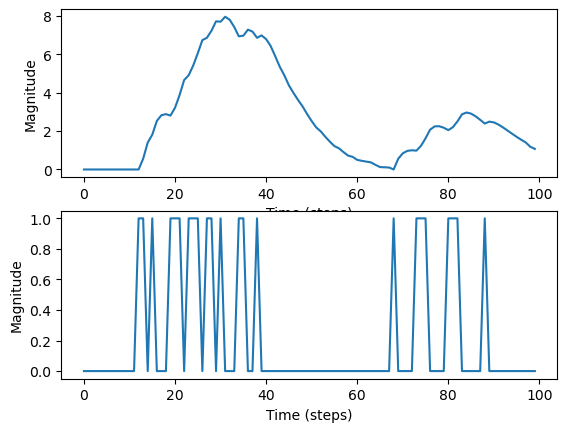

In [7]:
def getRandomTauHyperparameters(tau_rise_range=[2,10], tau_decay_range=[10,20]): # also add fast ones
    """
    Gets the randomly sampled tau hyperparameters.
  
    Parameters:
    tau_rise_range (list): default = [2,10]
    tau_decay_range (list): default = [10,20]
    
    Returns:
    tau_rise (int)
    tau_decay (float)
  
    """
    
    tau_rise = int(np.random.uniform(low=tau_rise_range[0] , high=tau_rise_range[1]))
    tau_decay = int(np.random.uniform(low=tau_decay_range[0], high=tau_decay_range[1]))
    
    # we don't want tau_rise to be bigger than tau_decay * safety_factor
    safety_factor = 1.5
    if tau_rise >= (tau_decay / safety_factor):
        tau_decay = safety_factor * tau_rise

    return tau_rise, tau_decay

def getDoubleExpFilteredSpikes_singleBatchExample(spikes, random_tau_constants, minimal_smoothing):
    """
    Gets the PSP shapes (smoothed input) for a single batch example.
  
    Parameters:
    spikes (tensor): 
    random_tau_constants (boolean): flag on the use of randomly sampled tau hyperparameters
    minimal_smoothing (boolean): flag on the use of fast tau hyperparameters for minimal input spike smoothing
  
    Returns:
    smoothed (tensor): smoothed input for a single batch example
  
    """
    
    # Define the tau and smoothing parameters
    if random_tau_constants: # Exp 2., Exp 3.
        tau_rise, tau_decay = getRandomTauHyperparameters()
        wd = int(tau_decay * 3)
    else: # Exp 1.
        if minimal_smoothing: # fast tau hyperparameters to preserve "spikiness"
            tau_rise, tau_decay, wd = 1, 1.5, 5 
        else: # normal smoothing to get PSPs 
            tau_rise, tau_decay, wd = 2, 10, 30
    # note: wd is the window size for the smoothing (in timesteps),
    # i.e. width (timesteps) of the smoothing to the left and the right of the spike timestep 
    
    spikes_numpy = spikes.detach().numpy() # (1,100,2000) because doing it for one example at a time
    
    # Define the double exponential kernel to obtain PSPs
    # See Book Chapter "Modeling Synapses" Equation (6.4) p.143
    # link: https://www.researchgate.net/profile/Mark-Van-Rossum/publication/266712567_Modeling_Synapses/links/546389350cf2c0c6aec4e4fe/Modeling-Synapses.pdf
    times = np.arange(spikes_numpy.shape[1]) # array from 0 to 100 (step=1)
    kernel = np.exp(-((times[0:0+wd]))/tau_decay) - np.exp(-((times[0:0+wd]))/tau_rise) 
    
    # kernel normalisation
    kernel_max = np.max(kernel)
    if kernel_max != 0:
        kernel /= kernel_max # normalise so that it peaks at 1 

    # Prepare spike window
    spike_window = np.concatenate((spikes_numpy[-wd:,:], spikes_numpy, spikes_numpy[:wd,:]))
    #print(spikeWindow.shape) # (3,100,2000)
    
    # Prepare smoothed array
    n_steps, n_neurons = spikes_numpy.shape[1], spikes_numpy.shape[2]
    smoothed = np.zeros(spikes_numpy.shape)
    
    # Add smoothing to every spike
    for n in range(n_neurons):
        for t in range(n_steps):
            # Only add kernel if there is a spike, otherwise don't change anything
            if spike_window[:,t,n].any() == 1:
                if t + wd <= n_steps: # there is space left
                    smoothed[:,t:t+wd, n] += kernel
                else: # there is no space left
                    updated_wd = n_steps - t
                    updated_kernel = np.exp(-((times[0:0+updated_wd]))/tau_decay) - np.exp(-((times[0:0+updated_wd]))/tau_rise)
                    #updated_kernel /= np.max(updated_kernel)
                    smoothed[:,t:t+updated_wd, n] += updated_kernel
                    
    # Return smoothed activity
    return torch.from_numpy(smoothed).type(torch.FloatTensor)

def getDoubleExpFilteredSpikes_allBatchExamples(presynaptic_input_spikes_tensor, random_tau_constants, minimal_smoothing):
    """
    Gets the PSP shapes (smoothed input) for all batch examples within a batch.
  
    Parameters:
    presynaptic_input_spikes_tensor (tensor): 
    random_tau_constants (boolean): flag on the use of randomly sampled tau hyperparameters
    minimal_smoothing (boolean): flag on the use of fast tau hyperparameters for minimal input spike smoothing
  
    Returns:
    input_smoothed (tensor): smoothed input for all batch examples of the current batch
  
    """
    
    # Prepare smoothed array with the first dimension including all batch examples
    input_smoothed = torch.zeros(presynaptic_input_spikes_tensor.shape) # (64,100,2000)
    
    # Do the smoothing for each example of the current batch (64 total)
    for i in range(BATCH_SIZE):
        input_smoothed_onebatch = getDoubleExpFilteredSpikes_singleBatchExample(presynaptic_input_spikes_tensor[i:i+1,:,:], random_tau_constants, minimal_smoothing) 
        input_smoothed[i:i+1,:,:] = input_smoothed_onebatch

    return input_smoothed

def plot_one_smoothed_neuron_activity():
    """
    Plots the smoothed activity of one input neuron in the first example of the first batch.
    E.g., 18th neuron out of 2000 neurons, 1st example out of 64, batch number 1
  
    Parameters:
    None
    
    Returns:
    None
  
    """
    
    # Generate the training data
    ipds, spikes = random_ipd_input_signal(NUM_SAMPLES)
       
    batch_number=0
    for x_local, y_local in data_generator(discretise(ipds), spikes):
        batch_number+=1
    
        # Show a single time series (for any of the 2000 input neurons and for any batch example)
        # e.g. 17th neuron, 1st batch example of batch number 1
        if batch_number == 1: 
            # smoothing for a single input spike train (e.g. the first spike train out of the 64 examples in the current batch group)
            input_smoothed = getDoubleExpFilteredSpikes_singleBatchExample(x_local[0:1,:,:], random_tau_constants=False, minimal_smoothing=False) 
        
            print("Example Spike Train #1/64 of Neuron #17 of Batch Group #{}".format(batch_number)) 
            plt.figure(1)

            plt.subplot(2,1,1)
            plt.plot(input_smoothed[0, :, 17].detach().numpy().T)
            plt.xlabel('Time (steps)')
            plt.ylabel('Magnitude')
    
            plt.subplot(2,1,2)
            plt.plot(x_local[0, :, 17].T)
            plt.xlabel('Time (steps)')
            plt.ylabel('Magnitude')
    
            plt.show()

plot_one_smoothed_neuron_activity()

---

Note: if the network performs at chance, the accuracy should be 1 out of 12 (since there are 12 classes).

## Exp 1. Training & Testing Results

### Minimal Input Smoothing (fast `tau_rise` and `tau_decay`)

  0%|          | 0/100 [00:00<?, ?it/s]

--------------------------------------------------------
EPOCH 1
---EPOCH 1: LOSS=2.58870
--------------------------------------------------------
EPOCH 2
---EPOCH 2: LOSS=2.48156
--------------------------------------------------------
EPOCH 3
---EPOCH 3: LOSS=2.43496
--------------------------------------------------------
EPOCH 4
---EPOCH 4: LOSS=2.40582
--------------------------------------------------------
EPOCH 5
---EPOCH 5: LOSS=2.37650
--------------------------------------------------------
EPOCH 6
---EPOCH 6: LOSS=2.34811
--------------------------------------------------------
EPOCH 7
---EPOCH 7: LOSS=2.31757
--------------------------------------------------------
EPOCH 8
---EPOCH 8: LOSS=2.28411
--------------------------------------------------------
EPOCH 9
---EPOCH 9: LOSS=2.25157
--------------------------------------------------------
EPOCH 10
---EPOCH 10: LOSS=2.22167
--------------------------------------------------------
EPOCH 11
---EPOCH 11: LOSS=2.19168
------

---EPOCH 90: LOSS=1.10702
--------------------------------------------------------
EPOCH 91
---EPOCH 91: LOSS=1.10080
--------------------------------------------------------
EPOCH 92
---EPOCH 92: LOSS=1.09409
--------------------------------------------------------
EPOCH 93
---EPOCH 93: LOSS=1.08788
--------------------------------------------------------
EPOCH 94
---EPOCH 94: LOSS=1.08179
--------------------------------------------------------
EPOCH 95
---EPOCH 95: LOSS=1.07512
--------------------------------------------------------
EPOCH 96
---EPOCH 96: LOSS=1.06909
--------------------------------------------------------
EPOCH 97
---EPOCH 97: LOSS=1.06289
--------------------------------------------------------
EPOCH 98
---EPOCH 98: LOSS=1.05764
--------------------------------------------------------
EPOCH 99
---EPOCH 99: LOSS=1.05107
--------------------------------------------------------
EPOCH 100
---EPOCH 100: LOSS=1.04531


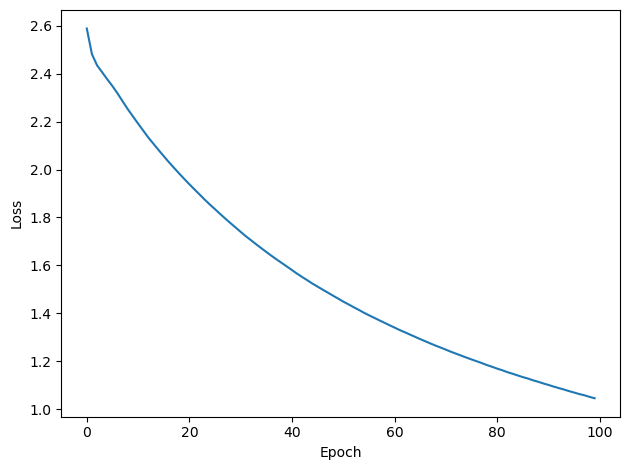

In [17]:
# training
# Generate the training data
ipds_train, spikes_train = random_ipd_input_signal(NUM_SAMPLES, usual_phase_delays=True)
Exp1Fast_W1_trained, W1_bis, Exp1Fast_W2_trained, Exp1Fast_snn_training_snapshot = train(ipds_train, spikes_train,
                                                                                         multiple_connections_per_axon=False,
                                                                                         random_tau_constants=False, 
                                                                                         minimal_smoothing=True)


Train classifier accuracy: 83.1%
Train absolute error: 4.6 deg

Test classifier accuracy: 77.4%
Test absolute error: 5.0 deg


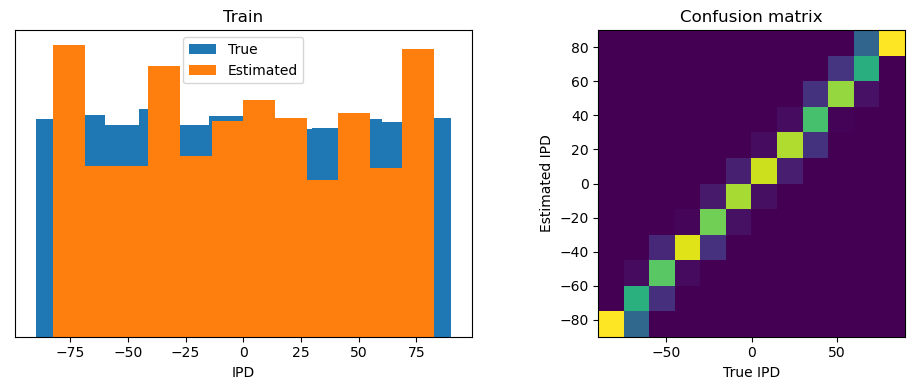

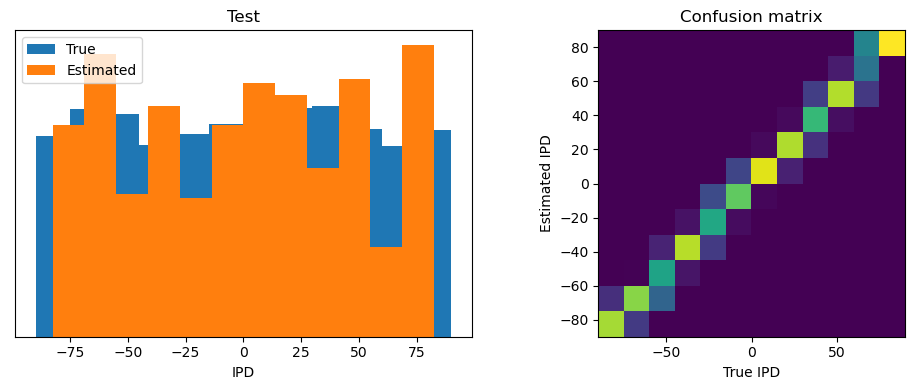

In [18]:
# training and testing accuracies
Exp1Fast_train_accuracy = analyse_accuracy(ipds_train, spikes_train, Exp1Fast_W1_trained, W1_bis, Exp1Fast_W2_trained, 
                                           multiple_connections_per_axon=False,
                                           random_tau_constants=False, 
                                           minimal_smoothing=True, 
                                           test_data=False)

# Generate the test data
ipds_test, spikes_test = random_ipd_input_signal(BATCH_SIZE*N_TESTING_BATCHES, usual_phase_delays=True)
Exp1Fast_test_accuracy = analyse_accuracy(ipds_test, spikes_test, Exp1Fast_W1_trained, W1_bis, Exp1Fast_W2_trained, 
                                          multiple_connections_per_axon=False,
                                          random_tau_constants=False, 
                                          minimal_smoothing=True, 
                                          test_data=True)

When minimal smoothing is applied, the network performs well as expected. The SNN here actually performs better than the SNN in the Starting Notebook on the TEST dataset (i.e., generalises better). The SNN Starting Notebook had the following: train accuracy = 82.9% (4.7 degree absolute error) and test accuracy = **54.8%** (7.9 degree absolute error). Could this tell us that some degree of smoothing on the input spike trains is actually beneficial, e.g. by removing some of the noise coming from the sparse input spike trains? Or, could some small degree of smoothing allow for a larger window of coincidence detection between two inputs while not completely sacrificing temporal information (given spike trains are more temporally precise). 

### Normal Input Smoothing

  0%|          | 0/100 [00:00<?, ?it/s]

--------------------------------------------------------
EPOCH 1
---EPOCH 1: LOSS=2.70504
--------------------------------------------------------
EPOCH 2
---EPOCH 2: LOSS=2.53907
--------------------------------------------------------
EPOCH 3
---EPOCH 3: LOSS=2.45401
--------------------------------------------------------
EPOCH 4
---EPOCH 4: LOSS=2.40007
--------------------------------------------------------
EPOCH 5
---EPOCH 5: LOSS=2.35672
--------------------------------------------------------
EPOCH 6
---EPOCH 6: LOSS=2.31837
--------------------------------------------------------
EPOCH 7
---EPOCH 7: LOSS=2.28152
--------------------------------------------------------
EPOCH 8
---EPOCH 8: LOSS=2.24591
--------------------------------------------------------
EPOCH 9
---EPOCH 9: LOSS=2.21480
--------------------------------------------------------
EPOCH 10
---EPOCH 10: LOSS=2.18274
--------------------------------------------------------
EPOCH 11
---EPOCH 11: LOSS=2.15206
------

---EPOCH 90: LOSS=1.05997
--------------------------------------------------------
EPOCH 91
---EPOCH 91: LOSS=1.05459
--------------------------------------------------------
EPOCH 92
---EPOCH 92: LOSS=1.04855
--------------------------------------------------------
EPOCH 93
---EPOCH 93: LOSS=1.04280
--------------------------------------------------------
EPOCH 94
---EPOCH 94: LOSS=1.03749
--------------------------------------------------------
EPOCH 95
---EPOCH 95: LOSS=1.03215
--------------------------------------------------------
EPOCH 96
---EPOCH 96: LOSS=1.02657
--------------------------------------------------------
EPOCH 97
---EPOCH 97: LOSS=1.02164
--------------------------------------------------------
EPOCH 98
---EPOCH 98: LOSS=1.01595
--------------------------------------------------------
EPOCH 99
---EPOCH 99: LOSS=1.01088
--------------------------------------------------------
EPOCH 100
---EPOCH 100: LOSS=1.00570


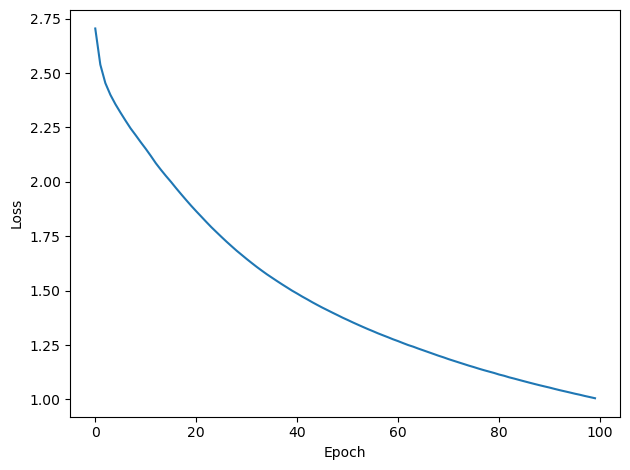

In [11]:
# training
# Generate the training data
ipds_train, spikes_train = random_ipd_input_signal(NUM_SAMPLES, usual_phase_delays=True)
Exp1_W1_trained, W1_bis, Exp1_W2_trained, snn_training_snapshot = train(ipds_train, spikes_train,
                                                                        multiple_connections_per_axon=False,
                                                                        random_tau_constants=False, 
                                                                        minimal_smoothing=False)


Train classifier accuracy: 77.6%
Train absolute error: 5.2 deg

Test classifier accuracy: 53.9%
Test absolute error: 8.7 deg


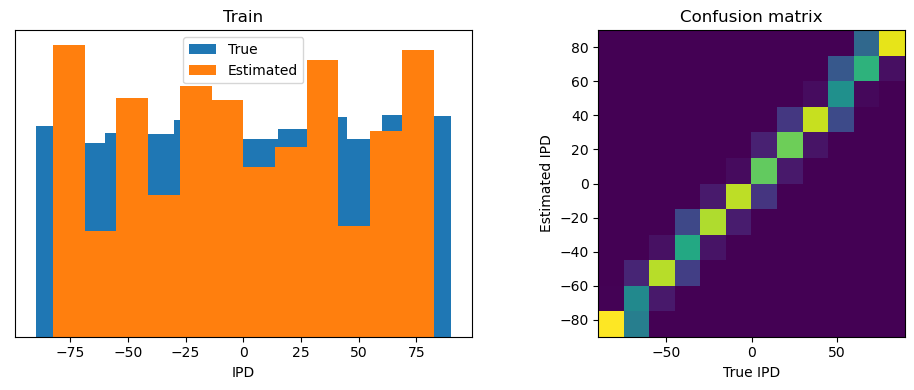

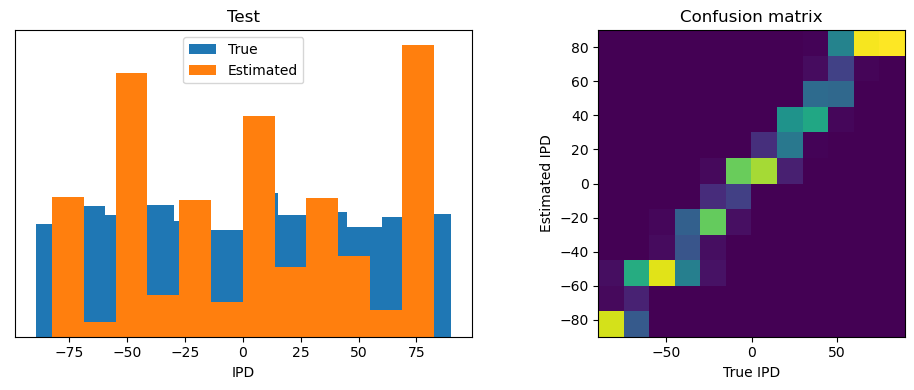

In [12]:
# training and testing accuracies
Exp1_train_accuracy = analyse_accuracy(ipds_train, spikes_train, Exp1_W1_trained, W1_bis, Exp1_W2_trained, 
                                       multiple_connections_per_axon=False,
                                       random_tau_constants=False, 
                                       minimal_smoothing=False, 
                                       test_data=False)
# Generate the test data
ipds_test, spikes_test = random_ipd_input_signal(BATCH_SIZE*N_TESTING_BATCHES, usual_phase_delays=True)
Exp1_test_accuracy = analyse_accuracy(ipds_test, spikes_test, Exp1_W1_trained, W1_bis, Exp1_W2_trained, 
                                      multiple_connections_per_axon=False,
                                      random_tau_constants=False, 
                                      minimal_smoothing=False, 
                                      test_data=True)

- The train and test accuracies are similar to the accuracies in the Starting Notebook, where train accuracy = 82.9% (4.7 degree absolute error) and test accuracy = 54.8% (7.9 degree absolute error). Note: the core differences between the notebooks in terms of hyperparameters is the learning rate (from 0.01 to 0.0001) and number of epochs (from 10 to 100).
- The confusion matrices look close to the confusion matrices in the Starting Notebook too, and are looking as expected (i.e., the network is making errors that are close to the true IPD, so there aren't vast differences between the estimated IPD and the true IPD). We might note something peculiar for true IPD > 50 in the confusion matrix on test data: It looks like for true IPDs that are greater than 50, the network is biased to output a higher estimate around 80 (why?). 

---

## Exp 2. Training & Testing Results

### Using the usual phase delays

  0%|          | 0/100 [00:00<?, ?it/s]

--------------------------------------------------------
EPOCH 1
---EPOCH 1: LOSS=3.40958
--------------------------------------------------------
EPOCH 2
---EPOCH 2: LOSS=2.72205
--------------------------------------------------------
EPOCH 3
---EPOCH 3: LOSS=2.51187
--------------------------------------------------------
EPOCH 4
---EPOCH 4: LOSS=2.44705
--------------------------------------------------------
EPOCH 5
---EPOCH 5: LOSS=2.40847
--------------------------------------------------------
EPOCH 6
---EPOCH 6: LOSS=2.37829
--------------------------------------------------------
EPOCH 7
---EPOCH 7: LOSS=2.35708
--------------------------------------------------------
EPOCH 8
---EPOCH 8: LOSS=2.33536
--------------------------------------------------------
EPOCH 9
---EPOCH 9: LOSS=2.31048
--------------------------------------------------------
EPOCH 10
---EPOCH 10: LOSS=2.28252
--------------------------------------------------------
EPOCH 11
---EPOCH 11: LOSS=2.26207
------

---EPOCH 90: LOSS=1.29086
--------------------------------------------------------
EPOCH 91
---EPOCH 91: LOSS=1.28954
--------------------------------------------------------
EPOCH 92
---EPOCH 92: LOSS=1.28230
--------------------------------------------------------
EPOCH 93
---EPOCH 93: LOSS=1.27364
--------------------------------------------------------
EPOCH 94
---EPOCH 94: LOSS=1.27162
--------------------------------------------------------
EPOCH 95
---EPOCH 95: LOSS=1.26588
--------------------------------------------------------
EPOCH 96
---EPOCH 96: LOSS=1.26003
--------------------------------------------------------
EPOCH 97
---EPOCH 97: LOSS=1.25150
--------------------------------------------------------
EPOCH 98
---EPOCH 98: LOSS=1.24451
--------------------------------------------------------
EPOCH 99
---EPOCH 99: LOSS=1.24208
--------------------------------------------------------
EPOCH 100
---EPOCH 100: LOSS=1.23542


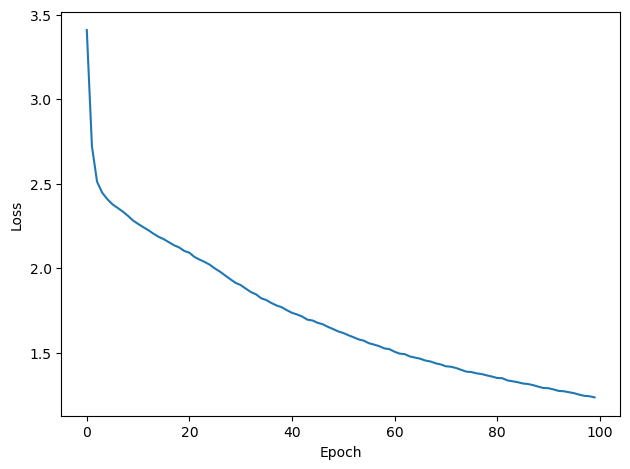

In [13]:
# training
# Generate the training data
ipds_train, spikes_train = random_ipd_input_signal(NUM_SAMPLES, usual_phase_delays=True)
Exp2A_W1_trained, W1_bis, Exp2A_W2_trained, snn_training_snapshot = train(ipds_train, spikes_train, 
                                                                          multiple_connections_per_axon=False,
                                                                          random_tau_constants=True, 
                                                                          minimal_smoothing=False)


Train classifier accuracy: 61.6%
Train absolute error: 7.6 deg

Test classifier accuracy: 29.2%
Test absolute error: 28.6 deg


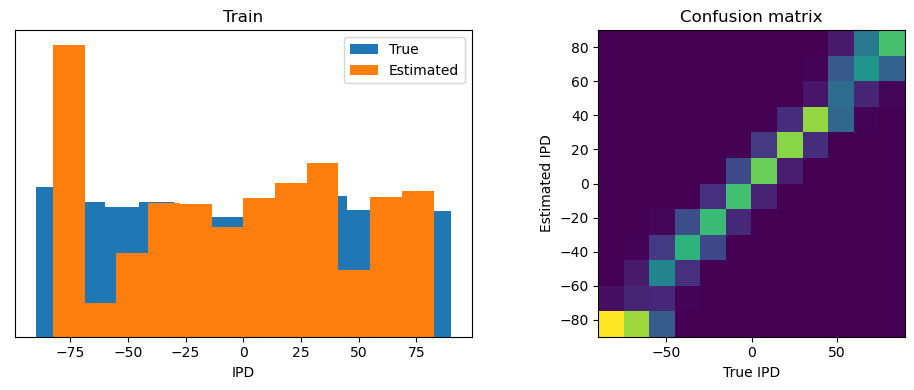

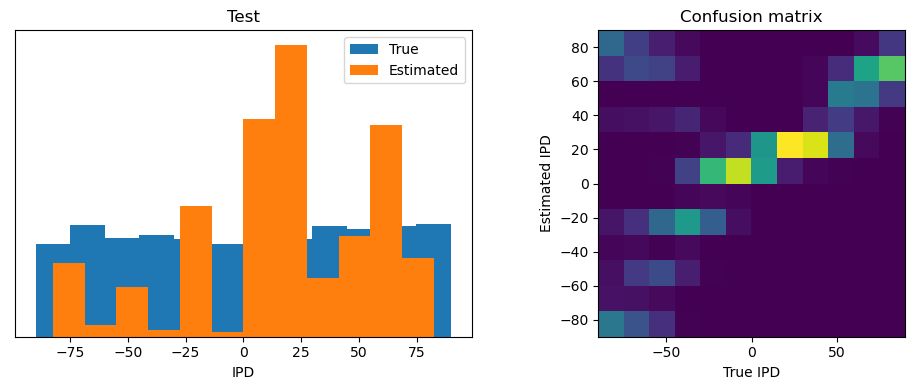

In [14]:
# training and testing accuracies
Exp2A_train_accuracy = analyse_accuracy(ipds_train, spikes_train, Exp2A_W1_trained, W1_bis, Exp2A_W2_trained, 
                                        multiple_connections_per_axon=False,
                                        random_tau_constants=True, 
                                        minimal_smoothing=False, 
                                        test_data=False)
# Generate the test data
ipds_test, spikes_test = random_ipd_input_signal(BATCH_SIZE*N_TESTING_BATCHES, usual_phase_delays=True)
Exp2A_test_accuracy = analyse_accuracy(ipds_test, spikes_test, Exp2A_W1_trained, W1_bis, Exp2A_W2_trained, 
                                       multiple_connections_per_axon=False,
                                       random_tau_constants=True, 
                                       minimal_smoothing=False, 
                                       test_data=True)

- While the confusion matrix for the training data looks relatively normal, the confusion matrix of the test data seems to suggest this:
    - for negative true IPDs, the network is biased to output lower estimated IPDs or much higher, positive IPDs; and it seems like only some values get outputted (-20, -50, -80)
    - for positive true IPDs, the network seems to perform a bit better, but there seems to be a range of true IPDs from 0 to 50, where the network is biased to output an estimate between 0 and 20.

### Using no phase delays

  0%|          | 0/100 [00:00<?, ?it/s]

--------------------------------------------------------
EPOCH 1
---EPOCH 1: LOSS=2.95107
--------------------------------------------------------
EPOCH 2
---EPOCH 2: LOSS=2.54748
--------------------------------------------------------
EPOCH 3
---EPOCH 3: LOSS=2.47353
--------------------------------------------------------
EPOCH 4
---EPOCH 4: LOSS=2.44364
--------------------------------------------------------
EPOCH 5
---EPOCH 5: LOSS=2.42513
--------------------------------------------------------
EPOCH 6
---EPOCH 6: LOSS=2.40976
--------------------------------------------------------
EPOCH 7
---EPOCH 7: LOSS=2.39648
--------------------------------------------------------
EPOCH 8
---EPOCH 8: LOSS=2.38305
--------------------------------------------------------
EPOCH 9
---EPOCH 9: LOSS=2.36896
--------------------------------------------------------
EPOCH 10
---EPOCH 10: LOSS=2.35604
--------------------------------------------------------
EPOCH 11
---EPOCH 11: LOSS=2.33839
------

---EPOCH 90: LOSS=1.62396
--------------------------------------------------------
EPOCH 91
---EPOCH 91: LOSS=1.61994
--------------------------------------------------------
EPOCH 92
---EPOCH 92: LOSS=1.61217
--------------------------------------------------------
EPOCH 93
---EPOCH 93: LOSS=1.60495
--------------------------------------------------------
EPOCH 94
---EPOCH 94: LOSS=1.60373
--------------------------------------------------------
EPOCH 95
---EPOCH 95: LOSS=1.59979
--------------------------------------------------------
EPOCH 96
---EPOCH 96: LOSS=1.59587
--------------------------------------------------------
EPOCH 97
---EPOCH 97: LOSS=1.58952
--------------------------------------------------------
EPOCH 98
---EPOCH 98: LOSS=1.58326
--------------------------------------------------------
EPOCH 99
---EPOCH 99: LOSS=1.58086
--------------------------------------------------------
EPOCH 100
---EPOCH 100: LOSS=1.57417


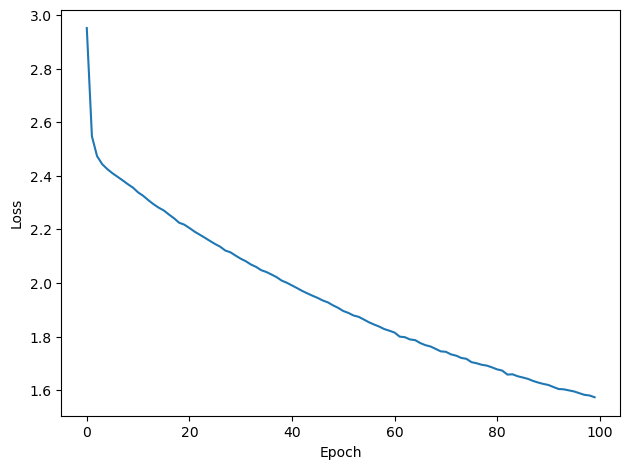

In [15]:
# training
# Generate the training data
ipds_train, spikes_train = random_ipd_input_signal(NUM_SAMPLES, usual_phase_delays=False)
Exp2B_W1_trained, W1_bis, Exp2B_W2_trained, snn_training_snapshot = train(ipds_train, spikes_train,
                                                                          multiple_connections_per_axon=False,
                                                                          random_tau_constants=True, 
                                                                          minimal_smoothing=False)


Train classifier accuracy: 51.9%
Train absolute error: 11.3 deg

Test classifier accuracy: 43.8%
Test absolute error: 15.6 deg


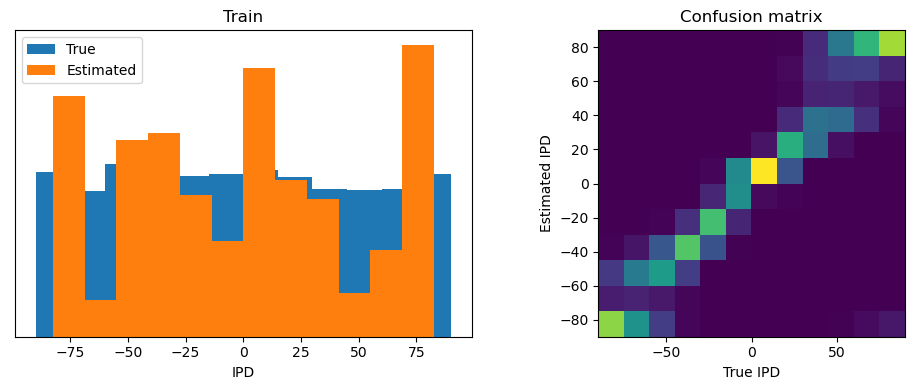

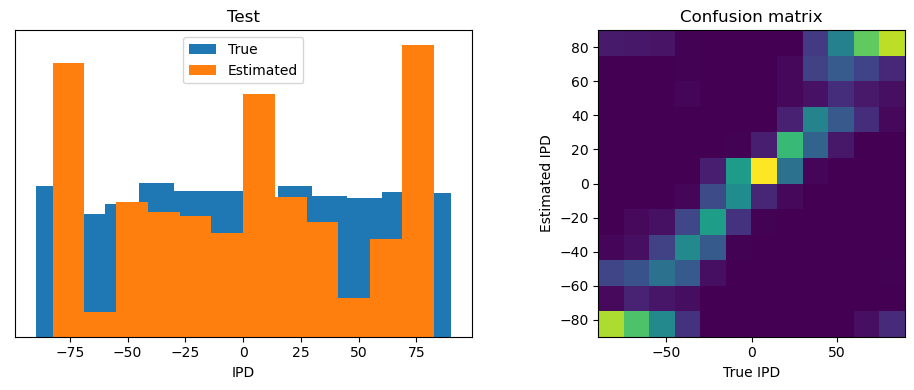

In [16]:
# training and testing accuracies
Exp2B_train_accuracy = analyse_accuracy(ipds_train, spikes_train, Exp2B_W1_trained, W1_bis, Exp2B_W2_trained, 
                                        multiple_connections_per_axon=False,
                                        random_tau_constants=True, 
                                        minimal_smoothing=False, 
                                        test_data=False)

# Generate the test data
ipds_test, spikes_test = random_ipd_input_signal(BATCH_SIZE*N_TESTING_BATCHES, usual_phase_delays=False)
Exp2B_test_accuracy = analyse_accuracy(ipds_test, spikes_test, Exp2B_W1_trained, W1_bis, Exp2B_W2_trained, 
                                       multiple_connections_per_axon=False,
                                       random_tau_constants=True, 
                                       minimal_smoothing=False, 
                                       test_data=True)

- Compared to Exp 2.a, the test accuracy here is larger (from 29.2% to 43.8%), suggesting that we might not need phase delays (i.e., set to 0). 
- We could try to train the network with null phase delays (like Exp 2.b here) and fixed `tau_rise` and `tau_decay` hyperparameters (like Exp 1 normal smoothing) to see if these two features work well together for the training on the sound localisation task.

---

## Exp 3. Training & Testing Results